# Modelisation de clustering

Ce notebook renferme les essais des différentes approches de modélisation pour segmenter nos données.

In [14]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

## Méthodes du projet

In [15]:
def plot_univarie(df, list_col, cust_bin=20):
    for col in list_col:
        print("-"*70)
        print("Colonne :", col)
        # mesures de tendances centrales
        print("moyenne : ", df[col].mean())
        print("médiane : ", df[col].median())
        print("mode : ", df[col].mode())
        print("min : ", df[col].min())
        print("max : ", df[col].max())
        quartiles = [np.percentile(df[col], p) for p in [25, 75]]
        print("quartiles : ", quartiles)
        # mesures de dispersion
        print("variance : ", df[col].var(ddof=0))
        print("écart-type : ", df[col].std(ddof=0))
        print("coefficient de variation : ", df[col].std(ddof=0)/df[col].mean())
        # mesures de forme
        print("skewness : ", df[col].skew())
        print("kurtosis : ", df[col].kurtosis())
        df[col].hist(bins=cust_bin)
        plt.xlabel(col)
        # pour tracer les 1er et 3ème quartiles
        min_ylim, max_ylim = plt.ylim()
        # plt.xticks(np.arange(-15, 41, 5))
        plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
        plt.text(quartiles[0], max_ylim*0.95, ' {:.0f}'.format(quartiles[0]))
        plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
        plt.text(quartiles[1], max_ylim*0.85, ' {:.0f}'.format(quartiles[1]))
        plt.show()
        print("-"*70)

In [16]:
# pour séparer les colonnes par type de donnée
def split_data_num_categ(df, silent=False):
    result = []
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    dict_col = {
        'numeric': [],
        'category': [],
        'boolean': [],
        'datetime': [],
        'deltatime': []
    }
    
    for col in df.columns:
        if df[col].dtype.name in ('float64', 'int64', 'int32'):
            dict_col['numeric'].append(col)
        elif df[col].dtype.name in ('object', 'category'):
            dict_col['category'].append(col)
        elif df[col].dtype.name == 'bool':
            dict_col['boolean'].append(col)
        elif df[col].dtype.name == 'datetime64[ns]':
            dict_col['datetime'].append(col)
        elif df[col].dtype.name == 'timedelta[ns]':
            dict_col['deltatime'].append(col)
        else:
            print("Type de données non connu :", df[col].dtype.name, "pour la colonne", col)

    if not silent:
        print("Voici la répartition des colonnes par type de données :")
    for key, value in dict_col.items():
        nb_col_by_type = len(value)
        if not silent:
            print(key, ":", nb_col_by_type, "colonnes.")
        if nb_col_by_type > 0:
            result.append(df[value])
    
    return result

In [17]:
# pour tracer les boxplot des différentes variables RFM en fonction du cluster
def display_box_plot_comparison(df_w_cluster, col_to_display):
    cluster_unique = sorted(df_w_cluster["cluster"].unique())
    X_quali = "cluster" # qualitative

    for col in col_to_display:
        Y_quanti = col # quantitative

        groupes = []
        for m in cluster_unique:
            groupes.append(df_w_cluster[df_w_cluster[X_quali]==m][Y_quanti])

        # Propriétés graphiques    
        medianprops = {'color':"black"}
        meanprops = {'marker':'o', 'markeredgecolor':'black',
                    'markerfacecolor':'firebrick'}
        plt.figure(figsize=(12,6))
        res = plt.boxplot(
            groupes, labels=cluster_unique, showfliers=False, medianprops=medianprops,
            vert=True, patch_artist=False, showmeans=True, meanprops=meanprops)
        plt.xlabel("Clusters")
        plt.ylabel("{} value".format(col))

        # pour tracer les lignes des limites pour discuter sur le graphique
        min_xlim, max_xlim = plt.xlim()
        boxes_lim = [item.get_ydata() for item in res['boxes']]
        for m in cluster_unique:
            temp_low = round(boxes_lim[m][1], 1)
            temp_up = round(boxes_lim[m][2], 1)
            plt.axhline(temp_low, color='k', linestyle='dashed', linewidth=1)
            plt.text(max_xlim*0.91, temp_low, '{}'.format(temp_low))
            plt.axhline(temp_up, color='k', linestyle='dashed', linewidth=1)
            plt.text(max_xlim*0.91, temp_up, '{}'.format(temp_up))

        plt.show()

In [18]:
import psutil, sys
def check_ressource_usage():
    user = 'slerendu'
    # vals_cpu = np.mean([p.cpu_percent() for p in psutil.process_iter() if p.username() == user])
    vals_ram = sum([p.memory_percent() for p in psutil.process_iter() if p.username() == user])
    # print("CPU :", round(vals_cpu, 1), "%")
    print("RAM :", round(vals_ram, 1), "%")
    if vals_ram > 90:
        sys.exit()

In [19]:
def compute_dbscan(X_norm, ref_labels, silent=True):
    start = time.time()
    result_dbscan = []
    min_sample_range = range(5, 25, 5)
    epsilon_range = np.arange(0.1, 0.9, 0.10)
    nb_tot_combin = len(min_sample_range) * len(epsilon_range)
    nb_current_combi = 0
    for i in min_sample_range:
        for j in epsilon_range:
            nb_current_combi += 1
            dbscan = cluster.DBSCAN(eps=j,  min_samples=i)
            dbscan.fit(X_norm)
            check_ressource_usage()
            labels = dbscan.labels_
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)
            ari_dbscan = round(adjusted_rand_score(ref_labels, labels), 4)
            if not silent:
                print("-"*70)
                print("Epsilon :", round(j, 1), "- MinSample :", i)
                print("Clusters :", n_clusters_, "- Noise points :", n_noise_)
                print("ARI-Score :", ari_dbscan)
            perc_curr = (nb_current_combi/nb_tot_combin)*100
            perc_remain = ((nb_tot_combin - nb_current_combi)/nb_tot_combin)*100
            print("-"*int(perc_curr) + " "*int(perc_remain) + str(round(perc_curr, 1)) + "%")
            result_dbscan.append([round(j, 1), i, n_clusters_, n_noise_, ari_dbscan])
    
    end = time.time()
    delta = round(end - start, 0)
    print("DBSCAN combinaisons parcourues en:", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")
    return pd.DataFrame(result_dbscan, columns=['eps', 'minsample', 'cluster', 'noise', 'ari'])

In [52]:
def display_bilan_clusters_all(df):
    agg = {}
    for col in df.columns:
        agg[col] = 'mean'
    agg['cluster'] = 'count'
    # on regroupe par customer_unique_id pour appliquer les aggrégations
    clustering_table = df.groupby(["cluster"]).agg(agg)
    # on renomme les colonnes pour l'étude des modèles
    clustering_table.rename(columns={'cluster': 'cluster_size'}, inplace=True)
    clustering_table["cluster_perc"] = round(clustering_table["cluster_size"] / len(df) * 100, 1)
    display(clustering_table.head())
    return clustering_table

### YellowBrick

In [20]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn import cluster
def define_cluster_numbers(X_norm, metric='distortion', nb_clusters=(2, 11)):
    start = time.time()
    
    clust = cluster.KMeans()
    visualizer = KElbowVisualizer(clust, metric=metric, k=nb_clusters)
    visualizer.fit(X_norm)
    visualizer.poof()
    
    end = time.time()
    delta = round(end - start, 0)
    print("Clusters définis en:", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")
    print("D'après cette analyse, le nombre de cluster optimal est de", visualizer.elbow_value_)
    return visualizer.elbow_value_

In [21]:
from yellowbrick.cluster import SilhouetteVisualizer
def display_silhouette_clusters(X_norm, nb_clusters=[]):
    start = time.time()
    if len(nb_clusters) == 0:
        print("La liste de nombre de clusters n'est pas renseignée.")
    else:
        for n_cluster in nb_clusters:
            print("Visualisation avec", n_cluster, "clusters en cours...")
            kmeans = cluster.KMeans(n_clusters=n_cluster)
            visualizer = SilhouetteVisualizer(kmeans)
            visualizer.fit(X_norm)
            visualizer.poof()
    
            end = time.time()
            delta = round(end - start, 0)
            start = time.time()
            print("Visualisation de Silhouette sur", n_cluster, " clusters fait en :", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")    

## Chargement des données

On commence par charger le dataset d'étude préparé dans le notebook d'analyse exploratoire.

In [22]:
data = pd.read_csv("study_dataset.csv", encoding='utf-8', sep='\t', index_col=0)

In [23]:
data.head()

,rfm_recency,rfm_frequency,rfm_monetary,panier_moyen,avance_sur_livraison_moyen,review_score_mean,fiche_score
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,141.90,4.132905,5.0,0.774648
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,27.19,4.248125,4.0,0.718310
0000f46a3911fa3c0805444483337064,537,1,86.22,86.22,1.389734,3.0,0.619718
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,43.62,11.108970,4.0,0.535211
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,196.89,7.035463,5.0,0.746479


# Clustering

In [24]:
from sklearn import cluster
from sklearn import preprocessing

In [59]:
col_to_study = ["rfm_recency", "rfm_frequency", "rfm_monetary"]#, "panier_moyen", "avance_sur_livraison_moyen", "review_score_mean", "fiche_score"]

In [61]:
# on prépare les données en les normalisant
X = data[col_to_study].values
scaler = preprocessing.RobustScaler()
X_norm = scaler.fit_transform(X)

## KMeans

### Recherche du nombre de clusters optimal

A l'aide du KMeans, on évalue le nombre de cluster optimal.

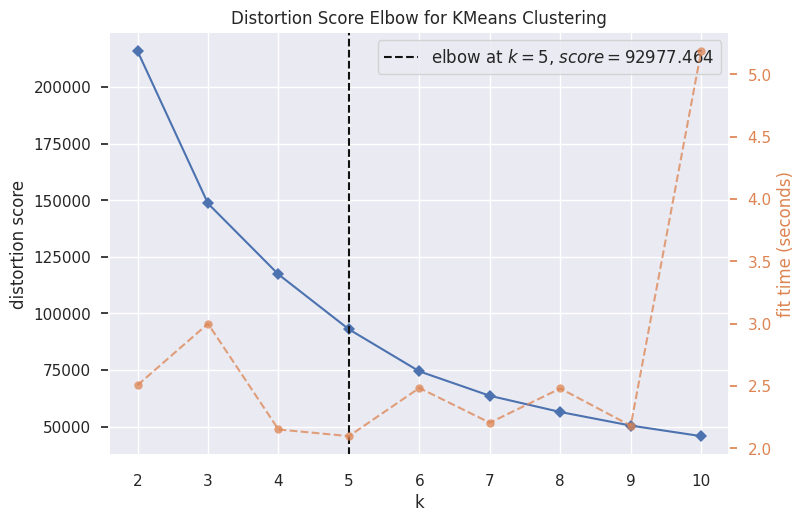

Clusters définis en: 25.0 s, soit 0.0 min, soit 0.0 h.
D'après cette analyse, le nombre de cluster optimal est de 5


In [62]:
optimal_k = define_cluster_numbers(X_norm)

Et on visualise le diagramme de silouhettes.

In [28]:
# display_silhouette_clusters(X_norm, nb_clusters=[optimal_k])

### Etude des clusters

In [29]:
# sns.reset_orig()

In [68]:
# on relance le KMeans avec le nb de cluster optimal
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(X_norm)
# puis on récupère le libellé du cluster pour chaque client
cluster_map = pd.DataFrame()
cluster_map['customer_unique_id'] = data.index.values
cluster_map['cluster'] = kmeans.labels_
# on incorpore cette données au dataframe global
data_w_cluster = pd.merge(data[col_to_study], cluster_map, on="customer_unique_id", how="inner")
data_w_cluster.set_index("customer_unique_id", inplace=True)

In [69]:
res = display_bilan_clusters_all(data_w_cluster)

,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,237.942561,1.045445,114.331434,83045,89.5
1,240.709497,1.507263,1851.735899,895,1.0
2,236.109359,1.351787,535.135838,8815,9.5


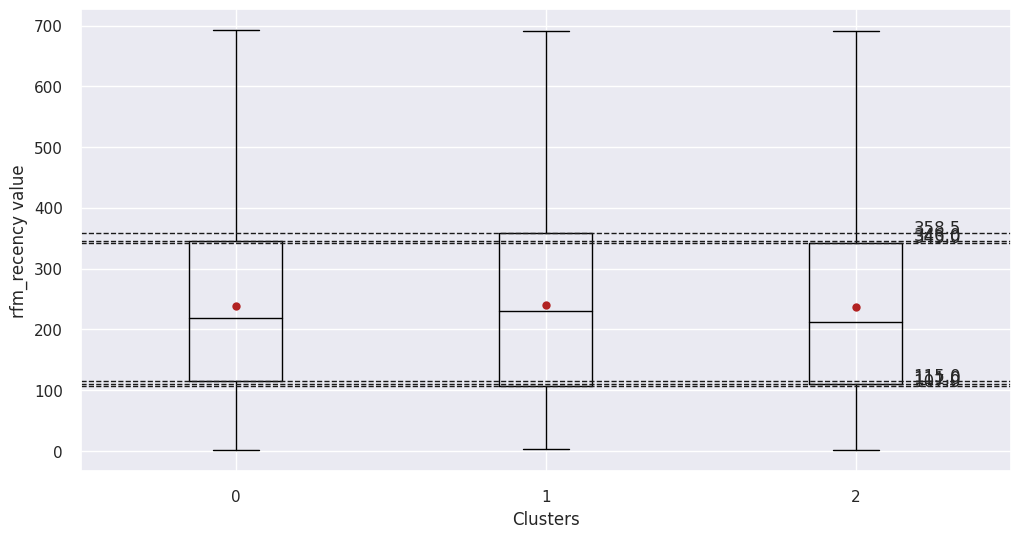

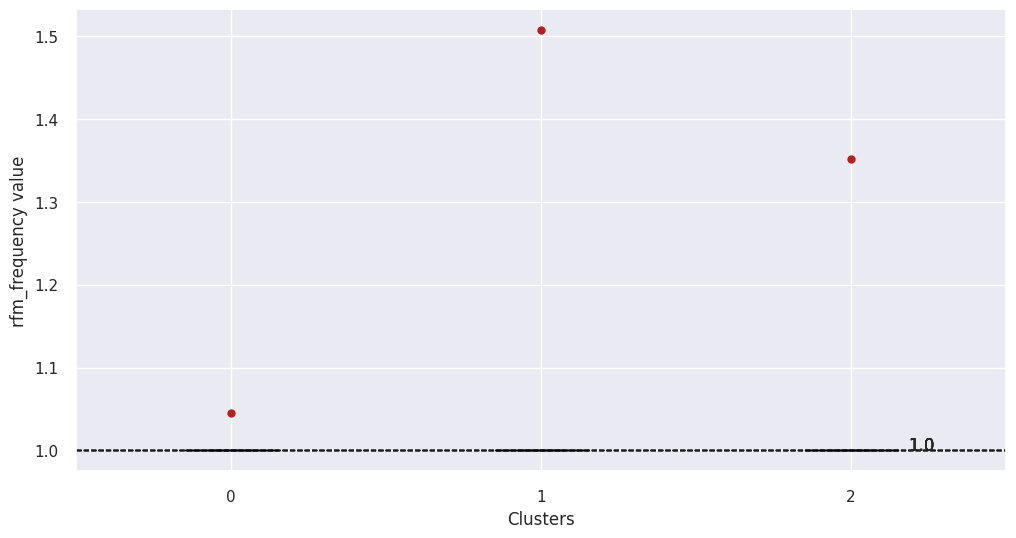

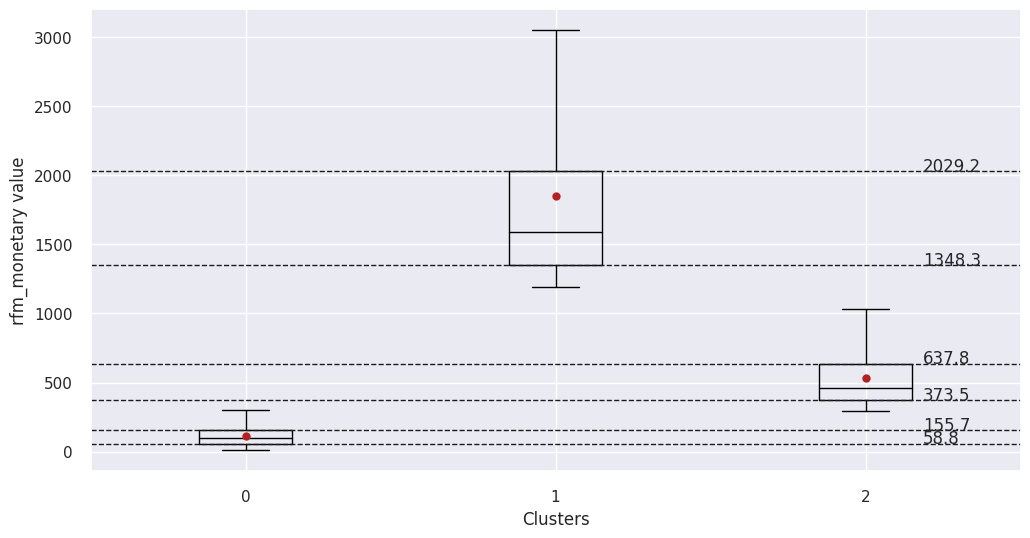

In [70]:
display_box_plot_comparison(data_w_cluster, col_to_study)

## Scénario avec KMeans

Nous allons maintenant voir l'intérêt du clustering par KMeans en calculant le gain obtenu selon différents scénario : 
 - nous allons déplacer 20% des petits acheteurs dans le cluster des bons acheteurs et comparer le CA
 - puis nous allons déplacer 20% des acheteurs moyens dans le cluster des bons acheteurs et comparer le CA

Nous allons donc d'abord calculer le CA global avec la configuration actuelle.

In [35]:
ca_global_ref = data_w_cluster["rfm_monetary"].sum()
print("Le CA global pour cette configuration est de", f'{round(ca_global_ref, 2):,}'.replace(',', ' '), "real.")

Le CA global pour cette configuration est de 16 284 435.75 real.


In [36]:
X = data_process.values
scaler = preprocessing.RobustScaler()
X_norm = scaler.fit_transform(X)

In [37]:
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(X_norm)
cluster_map = pd.DataFrame()
cluster_map['customer_unique_id'] = data_process.index.values
cluster_map['cluster'] = kmeans.labels_
# on incorpore cette données au dataframe global
data_w_cluster = pd.merge(data_process, cluster_map, on="customer_unique_id", how="inner")

In [38]:
res = display_bilan_clusters_rfm(data_w_cluster)

,recency_mean,frequency_mean,monetary_mean,cluster_size,cluster_perc
cluster,,,,,
0,243.630424,1.046668,114.272250,84597,89.3
1,248.423365,1.497320,1853.390804,933,1.0
2,241.210532,1.336960,531.839040,9191,9.7


In [39]:
res = res.sort_values(by="monetary_mean").reset_index(drop=True)

In [40]:
# on récupère les index de cluster par type
idx_clust_little = res.index[0]
idx_clust_medium = res.index[1]

In [41]:
# test du scénario 1
data_for_scene_01 = data_w_cluster.copy()
change = data_for_scene_01.loc[data_w_cluster["cluster"] == idx_clust_little, :].sample(frac = 0.2).index
data_for_scene_01.loc[change,'rfm_monetary'] = res.iloc[2].monetary_mean
ca_global_ref_scene_01 = data_for_scene_01["rfm_monetary"].sum()
print("Le CA global pour cette configuration est de",
      f'{round(ca_global_ref_scene_01, 2):,}'.replace(',', ' '),
      "real, une augmentation de", round((ca_global_ref_scene_01-ca_global_ref)/ca_global_ref*100, 2), "%")

Le CA global pour cette configuration est de 45 717 500.09 real, une augmentation de 180.74 %


In [42]:
# test du scénario 2
data_for_scene_02 = data_w_cluster.copy()
change = data_for_scene_02.loc[data_w_cluster["cluster"] == idx_clust_medium, :].sample(frac = 0.2).index
data_for_scene_02.loc[change,'rfm_monetary'] = res.iloc[2].monetary_mean
ca_global_ref_scene_02 = data_for_scene_02["rfm_monetary"].sum()
print("Le CA global pour cette configuration est de",
      f'{round(ca_global_ref_scene_02, 2):,}'.replace(',', ' '),
      "real, une augmentation de", round((ca_global_ref_scene_02-ca_global_ref)/ca_global_ref*100, 2), "%")

Le CA global pour cette configuration est de 16 300 974.9 real, une augmentation de 0.1 %
